# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [41]:
from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.utils.visualisations import Visualisation

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [42]:
bc_type = "impedance"       # Boundary condition type
probe_type = "airy_disk"    # Airy disk probe

# Constants
wavelength = 0.635e-6        # meters (0.5 μm)
k0 = 2 * np.pi / wavelength # wavenumber [1/m]

# Background refractive index
nb = 1.0

# Refractive index perturbation
delta = 0.001
beta = 0.001
refractive_index_perturbation = -delta - beta*1j

# Spatial dimensions (in meters)
xlims = [0.0, 300e-6]   # 10 μm = 1e-4 m
zlims = [0.0, 300e-6]   # 50 μm = 5e-4 m
continuous_dimensions = [xlims, zlims]

# Choose nz from paraxial resolution (Δz ≈ λ/2)
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)
print(f"{nz=}")


# Discrete space parameters
probe_dimensions = [64]    # Probe grid size in pixels
probe_diameter = int(0.4 * min(probe_dimensions))  # Diameter (fraction of grid)
scan_points = 3
step_size = 20             # pixels between scan points

# # Minimum nx from scan coverage
# min_nx = int(scan_points * step_size + probe_dimensions[0])
# print(f"{min_nx=}")

# Choose nx (≥ min_nx)
nx = 300

# Discrete pixel grid
discrete_dimensions = [nx, nz]

# Probe angle (in radians, default 0.0 → on-axis)
max_probe_angle = 0.1
num_angles = 3
probe_angles_list = [0] #np.linspace(-max_probe_angle,max_probe_angle,num_angles)
probe_focus = -0.00001 # focal length [m]
sample_space = SampleSpace(
    continuous_dimensions,   # meters
    discrete_dimensions,     # pixels (nx, nz)
    probe_dimensions,        # detector/probe window (pixels)
    scan_points,             # number of scan positions
    step_size,
    bc_type,                 # impedance / dirichlet / neumann
    probe_type,
    k0,                      # wavenumber [1/m]
    probe_focus=probe_focus,        
    n_medium=nb,
    probe_diameter=probe_diameter,
)

sample_space.summarize_sample_space()

nz=944
=== Scan Summary (Continuous) ===
  Sample space (x-range): 3.000e-04 m
  Sample space (z-range): 3.000e-04 m
  Probe diameter:         2.508e-05 m
  Number of scan points:  3
  Max Overlap:            5.017e-06 m
  Percentage Overlap:     20.00%



### 3. Create Sample Space

Initialize the sample space. The sample space dimensions are defined here as well
as it's discritization in pixels.

In [43]:

# sample_space = SampleSpace(
#     continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
#     discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
#     probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
#     scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
#     step_size,
#     bc_type,               # boundary condition type (impedance, dirichlet, neumann)
#     probe_type,
#     k0,            # wavenumber in 1/nm
#     probe_focus=0.0,
#     n_medium=nb,
#     probe_diameter=probe_diameter,
# )
# sample_space.summarize_sample_space()

### 4. Add Objects

Add rectangles with specified refractive indices to the sample space.

In [44]:
# gaussian_blur = 3

# # Add 6 spheres of varying diameters and positions
# common_side_length = 1  # μm diameter
# common_depth = 1  # μm depth

# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
#                         centre=(100/300*xlims[1], 50/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(150/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(200/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(220/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(125/300*xlims[1], 70/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(175/300*xlims[1], 50/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(100/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

### 5. Solve the Forward Model

Solve the forward problem both iteratively and as a full system for sub-samples
and the full sample.

In [45]:
# # Solve Thin Sample, Iterative
# forward_model_iterative_thin = ForwardModel(sample_space,
#                              full_system_solver=False,
#                              thin_sample=True)

# # Iterative solution
# print("Solving iteratively for thin sample...")
# solution_iterative_thin = forward_model_iterative_thin.solve(verbose=True)

In [46]:
# Solve Full Space Space, Iterative
forward_model_iterative_full = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=False,
                             probe_angles_list=probe_angles_list)

# Iterative solution
print("Solving iteratively for full sample...")
solution_iterative_full = forward_model_iterative_full.solve(verbose=True)


Solving iteratively for full sample...
Time to solve scan 1/3: 0.02302265167236328 seconds
Time to solve scan 2/3: 0.020873069763183594 seconds
Time to solve scan 3/3: 0.019854068756103516 seconds


In [47]:
# # Solve Full System, All-At-Once
# forward_model_fullsystem_thin = ForwardModel(sample_space,
#                              full_system_solver=True,
#                              thin_sample=True)

# # Full system solution
# print("Solving full system for thin sample...")
# solution_fullsystem_thin = forward_model_fullsystem_thin.solve(verbose=True)

### 6. Solve in Reverse
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [48]:
# # Set Exit wave to initial condition for reverse
# print("Solving iteratively for thin sample in reverse...")
# initial_condition = solution_iterative_thin[..., -1].copy()  # Copy the last frame of the solution
# solution_iterative_thin_reverse = forward_model_iterative_thin.solve(reverse=True,
#                                                       initial_condition=initial_condition)

# import numpy as np
# # Compute RMSE between solution_iterative_solve_thin_reverse and itself
# rmse = np.sqrt(np.mean(np.abs(solution_iterative_thin[..., 0] - solution_iterative_thin_reverse[..., -1]) ** 2))
# print(f"RMSE between forward and backward solutions: {rmse}")

In [49]:
# # Set Exit wave to initial condition for reverse
# print("Solving iteratively for full sample in reverse...")
# initial_condition = solution_iterative_full[..., -1].copy()  # Copy the last frame of the solution
# solution_iterative_full_reverse = forward_model_iterative_full.solve(reverse=True,
#                                                       initial_condition=initial_condition)

# import numpy as np
# # Compute RMSE between solution_iterative_solve_full_reverse and itself
# rmse = np.sqrt(np.mean(np.abs(solution_iterative_full[..., 0] - solution_iterative_full_reverse[..., -1]) ** 2))
# print(f"RMSE between forward and backward solutions: {rmse}")

### 7. Visualisations

Module to help view sample space and solutions.

In [50]:
# Import Visualisation module
from thick_ptycho.utils.visualisations import Visualisation

visualisation = Visualisation(sample_space=sample_space)

In [51]:
# # Visualise the Sample Space
# visualisation.plot(solution=sample_space.n_true,title="Sample Space")

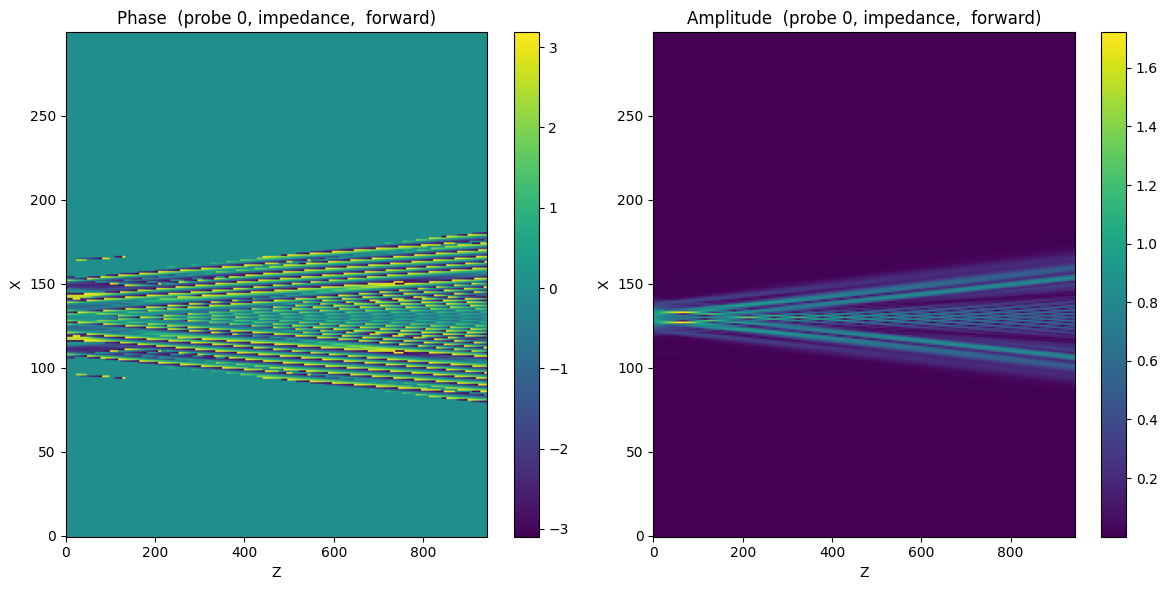

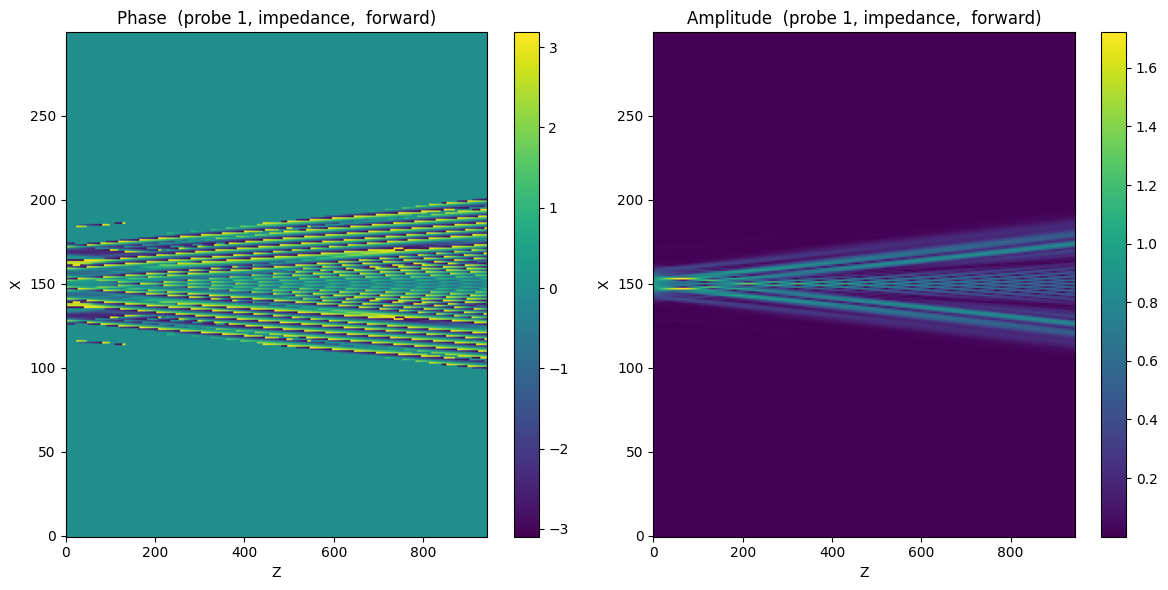

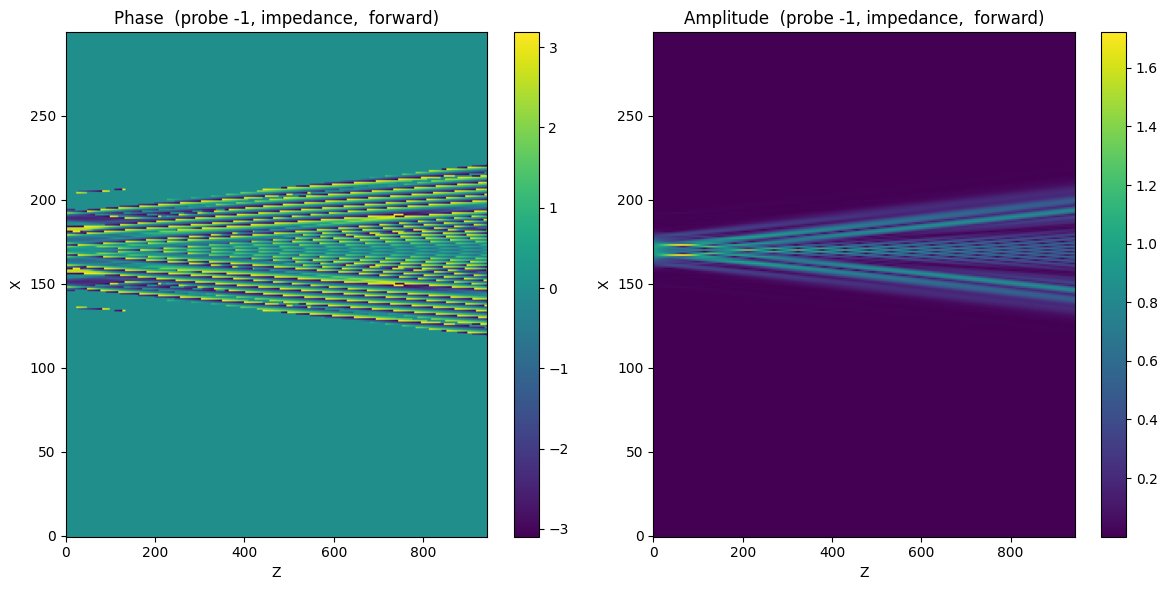

In [52]:
# Plot Solution for Full Sample Solves
plot_phase = True

visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase,probe_index=0)
visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase,probe_index=int(scan_points/2))
visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase,probe_index=-1)
# visualisation.plot(solution=solution_iterative_full[1], plot_phase=plot_phase,probe_index=-1)
# visualisation.plot(solution=solution_iterative_full[2], plot_phase=plot_phase,probe_index=-1)

### Compare with Homogeneous Sample

In [53]:
# sample_space = SampleSpace(
#     continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
#     discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
#     probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
#     scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
#     step_size,
#     bc_type,               # boundary condition type (impedance, dirichlet, neumann)
#     probe_type,
#     k0,            # wavenumber in 1/nm
#     n_medium=nb,
# )
# sample_space.generate_sample_space()

# # Solve Full Space Space, Iterative
# forward_model_iterative_full = ForwardModel(sample_space,
#                              full_system_solver=False,
#                              thin_sample=False,
#                              probe_angles=probe_angle)


# # Iterative solution
# print("Solving iteratively for full sample...")
# solution_iterative_full_homogeneous = forward_model_iterative_full.solve(verbose=True)

In [54]:
# difference = solution_iterative_full_homogeneous - solution_iterative_full
# # Plot Solution for Full Sample Solves
# plot_phase = False

# visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase)
# visualisation.plot(solution=solution_iterative_full[1], plot_phase=plot_phase)
# visualisation.plot(solution=solution_iterative_full[2], plot_phase=plot_phase)